In [1]:
import json
import os
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from imantics import Polygons

In [2]:
def create_stats(img_dir: str, annotation_filename: str = "annotation-bh.json"):
    annotation_json = os.path.join(img_dir, annotation_filename)
    with open(annotation_json, "r") as f:
        img_annotations = json.load(f)["_via_img_metadata"]
    hold_types_per_image = defaultdict(lambda: defaultdict(int))
    total_region_percentages = []
    for image in img_annotations.values():
        if not image["regions"]:
            # Skip images that have no region annotation, i.e. not annotated images
            continue
        if not all(
            [
                region["region_attributes"]["label_type"] == "handlabeled"
                for region in image["regions"]
            ]
        ):
            # Skip images which have regions that are not handlabeled
            continue
        image_filename = os.path.join(img_dir, image["filename"])
        height, width = cv2.imread(image_filename).shape[:2]
        area = height * width
        for region in image["regions"]:
            hold_type = region["region_attributes"]["hold_type"]
            hold_types_per_image[image["filename"].split(".")[0]][hold_type] += 1

            anno = region["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            polygons = [(x, y) for (x, y) in zip(px, py)]

            mask = Polygons(polygons=polygons).mask(height=height, width=width)
            percentage = (mask.sum() / area) * 100
            total_region_percentages.append(percentage)

    return hold_types_per_image, total_region_percentages

In [3]:
holds, region_percentage = create_stats("ml/cv-bh-data/")
df = pd.DataFrame.from_dict(holds)
df = df.transpose()

In [6]:
df.sum(axis=0)

hold      1408.0
volume      79.0
dtype: float64

Text(0.5, 1.0, 'Instances per category')

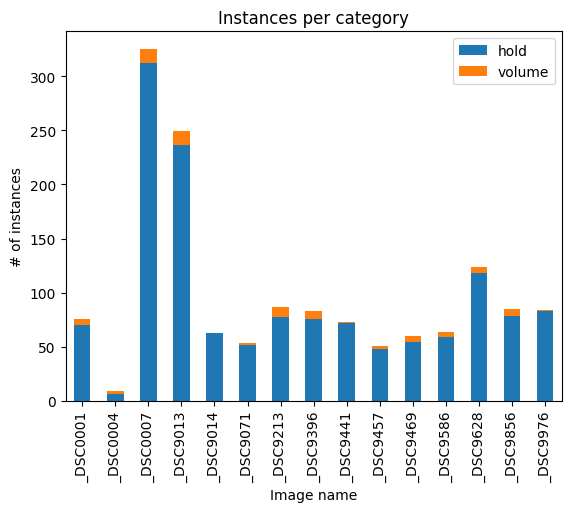

In [4]:
fig, ax = plt.subplots()
df.plot(ax=ax, kind="bar", stacked=True)
ax.set_ylabel("# of instances")
ax.set_xlabel("Image name")
ax.set_title("Instances per category")

Text(0.5, 1.0, 'Instance size')

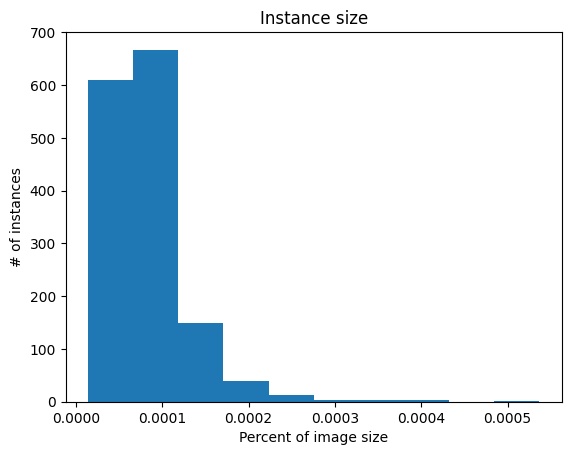

In [5]:
fig, ax = plt.subplots()
ax.hist(region_percentage)
ax.set_xlabel("Percent of image size")
ax.set_ylabel("# of instances")
ax.set_title("Instance size")